In [98]:
import pandas as pd

GAMES = [
    {
        "title": "Watch_Dogs",
        "slug": "watch_dogs",
        "release_date": "2014-07-05", 
        "csv_90d": "watch_dogs_reviews_first90d.csv",
    },
    {
        "title": "Watch_Dogs 2",
        "slug": "watch_dogs_2",
        "release_date": "2021-08-24",
        "csv_90d": "watch_dogs_2_reviews_first90d.csv",
    },
    {
        "title": "Watch Dogs: Legion",
        "slug": "watch_dogs_legion",
        "release_date": "2023-01-26",
        "csv_90d": "watch_dogs_legion_reviews_first90d.csv",
    },
]


Helper function to load the review data from each CSV based on the game title

In [100]:
def load_reviews_first90(game):
    path = './' + game["csv_90d"]
    print(path)
    df = pd.read_csv(path)
    
    df["game_title"] = game["title"]
    df["timestamp"] = pd.to_datetime(df["timestamp_created"], unit="s")
    df["date"] = df["timestamp"].dt.normalize()
    release_dt = pd.to_datetime(game["release_date"])
    df["days_since_release"] = (df["date"] - release_dt.normalize()).dt.days + 1
    df["review_length"] = df["review"].fillna("").str.split().str.len()
    df["voted_up"] = df["voted_up"].astype(int)
    
    return df

In [ ]:
all_dfs = {}

for game in GAMES:
    df = load_reviews_first90(game)
    all_dfs[game["slug"]] = df
    
    print(f"=== {game['title']} ===")
    print(df[[
        "recommendationid",
        "steamid",
        "timestamp",
        "days_since_release",
        "voted_up",
        "review_length"
    ]].head())

./watch_dogs_reviews_first90d.csv
=== Watch_Dogs ===
   recommendationid            steamid           timestamp  \
0          11092332  76561198067728268 2014-07-05 22:59:28   
1          11093969  76561198090002361 2014-07-06 01:27:43   
2          11094718  76561198106082353 2014-07-06 02:43:56   
3          11096383  76561198016425494 2014-07-06 05:48:05   
4          11096402  76561198107114953 2014-07-06 05:50:07   

   days_since_release  voted_up  review_length  
0                   1         0              9  
1                   2         1            184  
2                   2         1             16  
3                   2         1              4  
4                   2         1             22  
./watch_dogs_2_reviews_first90d.csv
=== Watch_Dogs 2 ===
   recommendationid            steamid           timestamp  \
0          98137385  76561198974152562 2021-08-24 08:27:44   
1          98138341  76561198988403227 2021-08-24 08:55:45   
2          98142206  7656119911116953

In [102]:
from collections import Counter
import re

POS_WORDS = {
    "good", "great", "amazing", "fun", "enjoyable", "awesome",
    "love", "liked", "fantastic", "nice", "beautiful", "addictive"
}
NEG_WORDS = {
    "bad", "terrible", "awful", "boring", "buggy", "crash", "crashes",
    "lag", "laggy", "broken", "refund", "garbage", "disappointing",
    "microtransactions", "paytowin", "pay-to-win"
}

'''
Takes a singular review and returns a sentiment score in [-1, 1] using 
a lexicon-based approach from predetermined positive and negative words that I defined above.
It then takes the sum of positive and negative words in the review to calculate the score
This just gives a rough idea of how positive or negative a review is
'''
def sentiment_score(text):
    if not isinstance(text, str):
        return 0.0
    #Tokenize the text into only lowercase words
    tokens = re.findall(r"[a-z']+", text.lower())

    #Count positive and negative words from our predefined sets
    pos = sum(t in POS_WORDS for t in tokens)
    neg = sum(t in NEG_WORDS for t in tokens)
    if pos == 0 and neg == 0:
        return 0.0
    #Calculate sentiment score based on counts
    return (pos - neg) / (pos + neg)   # in [-1, 1]

# Apply to each game's dataframe
for game in GAMES:
    slug = game["slug"]
    df = all_dfs[slug].copy()
    
    df["sentiment_simple"] = df["review"].apply(
        lambda x: 1 + (sentiment_score(x) + 1) * (9 / 2)
    )
    
    all_dfs[slug] = df


In [88]:
def summarize_early_reviews(df, game_title):

    first30 = df[df["days_since_release"].between(1, 30)].copy()
    week1 = first30[first30["days_since_release"].between(1, 7)]
    days8_30 = first30[first30["days_since_release"].between(8, 30)]
    
    summary = pd.Series({
        "game_title": game_title,
        "reviews_1_7": len(week1),
        "reviews_8_30": len(days8_30),
        "reviews_1_30": len(first30),
        "pos_rate_1_30": first30["voted_up"].mean() if len(first30) > 0 else None,
        "pos_rate_1_7": week1["voted_up"].mean() if len(week1) > 0 else None,
        "pos_rate_8_30": days8_30["voted_up"].mean() if len(days8_30) > 0 else None,
        "avg_review_len_1_30": first30["review_length"].mean() if len(first30) > 0 else None,
        "avg_sentiment_1_30": first30["sentiment_simple"].mean() if len(first30) > 0 else None,
        "avg_sentiment_1_7": week1["sentiment_simple"].mean() if len(week1) > 0 else None,
        "avg_sentiment_8_30": days8_30["sentiment_simple"].mean() if len(days8_30) > 0 else None,
    })
    
    return summary

In [ ]:
summaries = []

#Summarize each game's early reviews
for game in GAMES:
    df = all_dfs[game["slug"]]
    s = summarize_early_reviews(df, game["title"])
    summaries.append(s)

summary_df = pd.DataFrame(summaries)
summary_df

,game_title,reviews_1_7,reviews_8_30,reviews_1_30,pos_rate_1_30,pos_rate_1_7,pos_rate_8_30,avg_review_len_1_30,avg_sentiment_1_30,avg_sentiment_1_7,avg_sentiment_8_30
0,Watch_Dogs,159,344,503,0.642147,0.622642,0.651163,87.906561,6.341181,6.161995,6.424003
1,Watch_Dogs 2,87,519,606,0.841584,0.873563,0.836224,12.064356,5.898391,6.215517,5.845231
2,Watch Dogs: Legion,1034,550,1584,0.540404,0.528046,0.563636,49.407828,5.858407,5.753716,6.055224


For each game, I computed early-review features from the first 30 days of my dataset: how many reviews arrive in week 1 vs the rest of the month, how positive they are, and how long they are(text size).
We can see that Watch Dogs: Legion had by far the biggest early spike in review volume but also the lowest positivity, while Watch_Dogs 2 had fewer reviews early on but they were much more positive.

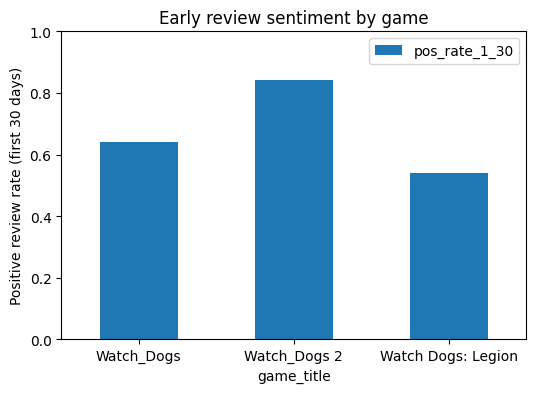

In [91]:
import matplotlib.pyplot as plt
summary_df[["game_title", "pos_rate_1_30"]].set_index("game_title").plot(
    kind="bar", figsize=(6,4)
)
plt.ylabel("Positive review rate (first 30 days)")
plt.title("Early review sentiment by game")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()


In [ ]:
summary_df[[
    "game_title",
    "avg_sentiment_1_30",
    "avg_sentiment_1_7",
    "avg_sentiment_8_30"
]]

,game_title,avg_sentiment_1_30,avg_sentiment_1_7,avg_sentiment_8_30
0,Watch_Dogs,6.341181,6.161995,6.424003
1,Watch_Dogs 2,5.898391,6.215517,5.845231
2,Watch Dogs: Legion,5.858407,5.753716,6.055224


Here I did lexicon based sentiment analysis using some common words used in the reviews and gave those words a weight of being bad or good. Then I calculated the average sentiment score for reviews. This gives us a better idea of how positive or negative the reviews were rather than just the positive review rate. 

I want to change this to VADER sentiment analysis later on using the nltk library but I was having some issues installing it.

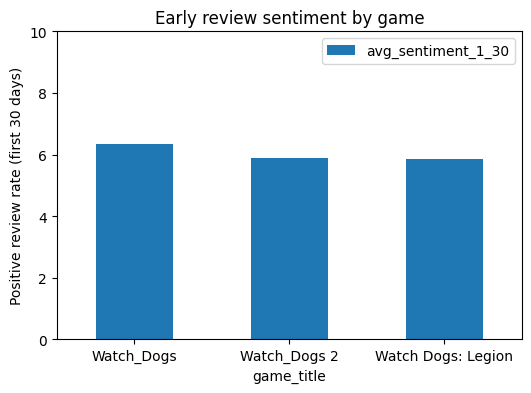

In [97]:
summary_df[["game_title", "avg_sentiment_1_30"]].set_index("game_title").plot(
    kind="bar", figsize=(6,4)
)
plt.ylabel("Positive review rate (first 30 days)")
plt.title("Early review sentiment by game")
plt.xticks(rotation=0)
plt.ylim(0, 10)
plt.show()


From the above analysis, we can see that Watch dogs had the highest average sentiment score in the first 30 days wheras in watch dogs 2 had the highest positive review rate. This shows that sentiment score can give us a better idea of how positive the reviews were rather than just the positive review rate. We can also get a better understanding of this after we perform VADER sentiment analysis on these reviews since VADER is more robust and takes into account the context of the words used in the reviews wheras our lexicon based approach just counts the number of positive and negative words.